In [42]:
from keras.applications import VGG16
from keras import backend as K

In [43]:
model = VGG16(weights = 'imagenet',
             include_top = False)

In [44]:
import numpy as np 

In [45]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [58]:
def generate_pattern(layer_name, filter_index, size = 150):
    layer_ouput = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    grads = K.gradients(loss , model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input],[loss,grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

In [59]:
import matplotlib.pyplot as plt

In [60]:
def generate_pattern64(layer_name):
    size = 64
    margin = 5
    
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
    
    for i in range (8):
        for j in range(8):
            filter_img = generate_pattern(layer_name, i + (j * 8), size = size)
            
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
    plt.figure(figsize = (20,20))
    plt.imshow(results)
    return

In [70]:
model = VGG16(weights = 'imagenet')
from keras.preprocessing import image
import cv2
from keras.applications.vgg16 import preprocess_input, decode_predictions
def heatmap_pred(img_name):
    img_path = img_name + '.jpg'
    img = image.load_img(img_path, target_size = (224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    
    preds = model.predict(x)
    print('Predicted: ' , decode_predictions(preds, top = 3)[0])
    
    num = np.argmax(preds[0])
    
    out = model.output[:, num]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(out, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis = (0, 1, 2))
    iterate = K.function([model.input] , [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis = -1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.matshow(heatmap)
    
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite(img_name + 'photo_cam.jpg', superimposed_img)
    return

Predicted:  [('n07615774', 'ice_lolly', 0.11668378), ('n04270147', 'spatula', 0.07388386), ('n07714990', 'broccoli', 0.042944748)]


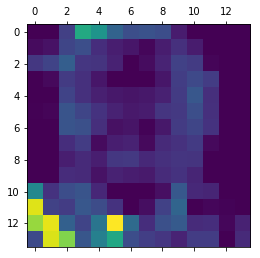

In [81]:
heatmap_pred('a')